In [42]:
# TimeGAN PyTorch Implementation
# Converted from TensorFlow 2.x to PyTorch

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# import F
from torch.nn.utils import clip_grad_norm_
import torch.nn.functional as F

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [43]:
###############################################################################
# 1) Utilities: batch generator, min-max scaling
###############################################################################

def batch_generator(data, batch_size):
    """
    Randomly samples a subset of data (batch_size)
    """
    idx = np.random.permutation(len(data))[:batch_size]
    return data[idx]

def min_max_scale(data):
    """
    Scale entire 3D array to [0,1].
    Returns scaled_data, min_val, max_val (all float32).
    """
    min_val = np.min(data, axis=(0,1), keepdims=True)
    data_ = data - min_val
    max_val = np.max(data_, axis=(0,1), keepdims=True)
    data_ = data_ / (max_val + 1e-7)
    return data_.astype(np.float32), min_val.astype(np.float32), max_val.astype(np.float32)

In [44]:
###############################################################################
# 2) Data: FM/AM sinusoid generation, float32
###############################################################################

def sine_data_generation(
    n_samples=10000,         # number of samples
    seq_len=1.0,             # duration (seconds)
    dim=1,                   # channels
    sampling_rate=100.0,     # samples per second
    base_freq=5.0,           # mean frequency (Hz)
    freq_mod_rate=None,
    freq_mod_depth=None,
    amp_mod_rate=None,
    amp_mod_depth=None,
    modulation='both'   # 'FM', 'AM', or 'both'
):

    if freq_mod_rate is None:
        freq_mod_rate = np.random.uniform(5, 30)
    if freq_mod_depth is None:
        freq_mod_depth = np.random.uniform(0.05, 0.2) * base_freq # scale by base_f
    if amp_mod_rate is None:
        amp_mod_rate = np.random.uniform(30, 50) # AM MOD RATE 5, 30 >> 30, 180
    if amp_mod_depth is None:
        amp_mod_depth = np.random.uniform(0.13, 0.18) # smaller modulation

    n_timesteps = int(seq_len * sampling_rate)
    t = np.linspace(0, seq_len, n_timesteps, endpoint=False)
    data = []

    for _ in range(n_samples):
        seq = []
        for _ in range(dim):

            # Random carrier parameters
            f = np.random.normal(loc=base_freq, scale=0.5)
            initial_phase = np.random.uniform(0, 2 * np.pi)

            # Fixed carrier parameters
            # f = base_freq
            # initial_phase = 0

            # FM
            if modulation in ['FM', 'both']:
                fm_phase = np.random.uniform(0, 2 * np.pi)

                # f(t) = f + d_F * sin(2π * freq_mod_rate * t + fm_phase)
                freq_offset = freq_mod_depth * np.sin(2 * np.pi * freq_mod_rate * t + fm_phase)
                instantaneous_freq = f + freq_offset
                instantaneous_phase = 2 * np.pi * np.cumsum(instantaneous_freq) / sampling_rate + initial_phase
            else:
                instantaneous_phase = 2 * np.pi * f * t + initial_phase

            # AM
            if modulation in ['AM', 'both']:
                am_phase = np.random.uniform(0, 2 * np.pi)
                # A(t) = 1 + d_A * sin(2π * amp_mod_rate * t + am_phase)
                amplitude_envelope = 1 + amp_mod_depth * np.sin(2 * np.pi * amp_mod_rate * t + am_phase)
            else:
                amplitude_envelope = np.ones_like(t)

            # x(t) = A(t) * sin(θ(t))
            x = amplitude_envelope * np.sin(instantaneous_phase)
            seq.append(x)

        seq = np.transpose(np.array(seq))
        data.append(seq)

    data = np.array(data, dtype=np.float32)
    return data

In [45]:

###############################################################################
# 3) Sub-networks (PyTorch)
###############################################################################

class Embedder(nn.Module):
    def __init__(self, hidden_dim=24, num_layers=3, rnn_type='gru'):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn_type = rnn_type

        self.rnns = nn.ModuleList()
        for _ in range(num_layers):
            if rnn_type == 'gru':
                self.rnns.append(nn.GRU(hidden_dim, hidden_dim, batch_first=True))
            else:
                self.rnns.append(nn.LSTM(hidden_dim, hidden_dim, batch_first=True))

        self.fc = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x):
        # First layer takes input dimension
        if self.rnn_type == 'gru':
            h, _ = self.rnns[0](x)
        else:
            h, _ = self.rnns[0](x)
        h = torch.tanh(h)

        # Subsequent layers
        for i in range(1, self.num_layers):
            if self.rnn_type == 'gru':
                h, _ = self.rnns[i](h)
            else:
                h, _ = self.rnns[i](h)
            h = torch.tanh(h)

        return torch.sigmoid(self.fc(h))

class Recovery(nn.Module):
    def __init__(self, hidden_dim=24, out_dim=5, num_layers=3, rnn_type='gru'):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn_type = rnn_type

        self.rnns = nn.ModuleList()
        for _ in range(num_layers):
            if rnn_type == 'gru':
                self.rnns.append(nn.GRU(hidden_dim, hidden_dim, batch_first=True))
            else:
                self.rnns.append(nn.LSTM(hidden_dim, hidden_dim, batch_first=True))

        self.fc = nn.Linear(hidden_dim, out_dim)

    def forward(self, h):
        x_ = h
        for rnn in self.rnns:
            if self.rnn_type == 'gru':
                x_, _ = rnn(x_)
            else:
                x_, _ = rnn(x_)
            x_ = torch.tanh(x_)

        return torch.sigmoid(self.fc(x_))

class Generator(nn.Module):
    def __init__(self, hidden_dim=24, num_layers=3, rnn_type='gru'):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn_type = rnn_type

        self.rnns = nn.ModuleList()
        for _ in range(num_layers):
            if rnn_type == 'gru':
                self.rnns.append(nn.GRU(hidden_dim, hidden_dim, batch_first=True))
            else:
                self.rnns.append(nn.LSTM(hidden_dim, hidden_dim, batch_first=True))

        self.fc = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, z):
        e = z
        for rnn in self.rnns:
            if self.rnn_type == 'gru':
                e, _ = rnn(e)
            else:
                e, _ = rnn(e)
            e = torch.tanh(e)

        return torch.sigmoid(self.fc(e))

class Supervisor(nn.Module):
    def __init__(self, hidden_dim=24, num_layers=3, rnn_type='gru'):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn_type = rnn_type

        self.rnns = nn.ModuleList()
        for _ in range(num_layers-1):
            if rnn_type == 'gru':
                self.rnns.append(nn.GRU(hidden_dim, hidden_dim, batch_first=True))
            else:
                self.rnns.append(nn.LSTM(hidden_dim, hidden_dim, batch_first=True))

        self.fc = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, h):
        s = h
        for rnn in self.rnns:
            if self.rnn_type == 'gru':
                s, _ = rnn(s)
            else:
                s, _ = rnn(s)
            s = torch.tanh(s)

        return torch.sigmoid(self.fc(s))

class Discriminator(nn.Module):
    def __init__(self, hidden_dim=24, num_layers=3, rnn_type='gru'):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn_type = rnn_type

        self.rnns = nn.ModuleList()
        for _ in range(num_layers):
            if rnn_type == 'gru':
                self.rnns.append(nn.GRU(hidden_dim, hidden_dim, batch_first=True))
            else:
                self.rnns.append(nn.LSTM(hidden_dim, hidden_dim, batch_first=True))

        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, h):
        d = h
        for rnn in self.rnns:
            if self.rnn_type == 'gru':
                d, _ = rnn(d)
            else:
                d, _ = rnn(d)
            d = torch.tanh(d)

        return self.fc(d)

In [46]:
###############################################################################
# 4) TimeGAN class (PyTorch)
###############################################################################

class TimeGAN(nn.Module):
    def __init__(self, seq_len, dim,
                hidden_dim: int = 24,
                num_layers: int = 3,
                module: str = "gru",
                gamma: float = 1.0,
                e_init_lr: float = 1e-3,
                g_init_lr: float = 1e-4,
                d_init_lr: float = 1e-4,
                decay_steps: int = 5_000,
                restarts: int = 2):
        super().__init__()

        # hyperparameters
        self.seq_len = seq_len
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.module = module
        self.gamma = gamma
        self.device = device

        # sub-networks
        self.embedder = Embedder(hidden_dim, num_layers, module).to(device)
        self.recovery = Recovery(hidden_dim, dim, num_layers, module).to(device)
        self.generator = Generator(hidden_dim, num_layers, module).to(device)
        self.supervisor = Supervisor(hidden_dim, num_layers, module).to(device)
        self.discriminator = Discriminator(hidden_dim, num_layers, module).to(device)

        # Fix input dimensions for first layers
        self.embedder.rnns[0] = nn.GRU(dim, hidden_dim, batch_first=True).to(device) if module == 'gru' else nn.LSTM(dim, hidden_dim, batch_first=True).to(device)
        self.recovery.rnns[0] = nn.GRU(hidden_dim, hidden_dim, batch_first=True).to(device) if module == 'gru' else nn.LSTM(hidden_dim, hidden_dim, batch_first=True).to(device)
        self.generator.rnns[0] = nn.GRU(dim, hidden_dim, batch_first=True).to(device) if module == 'gru' else nn.LSTM(dim, hidden_dim, batch_first=True).to(device)
        self.supervisor.rnns[0] = nn.GRU(hidden_dim, hidden_dim, batch_first=True).to(device) if len(self.supervisor.rnns) > 0 else None
        self.discriminator.rnns[0] = nn.GRU(hidden_dim, hidden_dim, batch_first=True).to(device) if module == 'gru' else nn.LSTM(hidden_dim, hidden_dim, batch_first=True).to(device)

        # optimizers with cosine annealing
        self.e_optimizer = optim.Adam(
            list(self.embedder.parameters()) + list(self.recovery.parameters()),
            lr=e_init_lr, eps=1e-8
        )
        self.g_optimizer = optim.Adam(
            list(self.generator.parameters()) + list(self.supervisor.parameters()),
            lr=g_init_lr, eps=1e-8
        )
        self.d_optimizer = optim.Adam(
            self.discriminator.parameters(),
            lr=d_init_lr, eps=1e-8
        )

        # learning rate schedulers
        self.e_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.e_optimizer, T_0=decay_steps, T_mult=restarts, eta_min=e_init_lr*0.1
        )
        self.g_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.g_optimizer, T_0=decay_steps, T_mult=restarts, eta_min=g_init_lr*0.1
        )
        self.d_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.d_optimizer, T_0=decay_steps, T_mult=restarts, eta_min=d_init_lr*0.1
        )

        # gradient clipping
        self.clip_norm = 1.0

    def train_embedder(self, x):
        """Phase 1: embedder/recovery MSE AE loss."""
        x = torch.tensor(x, dtype=torch.float32).to(self.device)

        self.embedder.train()
        self.recovery.train()
        self.e_optimizer.zero_grad()

        h = self.embedder(x)
        x_tilde = self.recovery(h)
        e_mse = torch.mean((x - x_tilde)**2)
        e_loss = 10.0 * torch.sqrt(e_mse)

        e_loss.backward()
        nn.utils.clip_grad_norm_(list(self.embedder.parameters()) + list(self.recovery.parameters()), self.clip_norm)
        self.e_optimizer.step()
        self.e_scheduler.step()

        return e_loss

    def train_supervised(self, x):
        """Phase 2: supervised next-step prediction in latent space."""
        x = torch.tensor(x, dtype=torch.float32).to(self.device)

        self.embedder.eval()
        self.generator.train()
        self.supervisor.train()
        self.g_optimizer.zero_grad()

        with torch.no_grad():
            h = self.embedder(x)

        h_hat_sup = self.supervisor(h)
        s_mse = torch.mean((h[:, 1:, :] - h_hat_sup[:, :-1, :])**2)

        s_mse.backward()
        nn.utils.clip_grad_norm_(list(self.generator.parameters()) + list(self.supervisor.parameters()), self.clip_norm)
        self.g_optimizer.step()
        self.g_scheduler.step()

        return s_mse

    def train_joint(self, x):
        """
        Phase 3: Joint training
        2 generator updates, 1 discriminator update each step.
        """
        x = torch.tensor(x, dtype=torch.float32).to(self.device)
        batch_size = x.shape[0]

        # Set all networks to training mode once
        self.embedder.train()
        self.recovery.train()
        self.generator.train()
        self.supervisor.train()
        self.discriminator.train()

        # 1) Generator updates
        self.g_optimizer.zero_grad()
        self.e_optimizer.zero_grad()

        # Real path
        h = self.embedder(x)
        x_tilde = self.recovery(h)

        # Fake path
        z = torch.randn(batch_size, self.seq_len, self.dim, device=self.device)
        e_hat = self.generator(z)
        h_hat = self.supervisor(e_hat)
        x_hat = self.recovery(h_hat)

        # Supervisor path
        h_hat_sup = self.supervisor(h)

        # Discriminator outputs for generator training
        y_fake = self.discriminator(h_hat)
        y_fake_e = self.discriminator(e_hat)

        # Generator losses
        g_loss_u = torch.mean(torch.nn.functional.binary_cross_entropy_with_logits(
            y_fake, torch.ones_like(y_fake)
        ))
        g_loss_u_e = torch.mean(torch.nn.functional.binary_cross_entropy_with_logits(
            y_fake_e, torch.ones_like(y_fake_e)
        ))

        g_loss_s = torch.mean((h[:, 1:, :] - h_hat_sup[:, :-1, :])**2)

        # Moment matching loss
        x_mean = torch.mean(x, dim=[0, 1])
        x_var = torch.var(x, dim=[0, 1])
        x_hat_mean = torch.mean(x_hat, dim=[0, 1])
        x_hat_var = torch.var(x_hat, dim=[0, 1])

        g_loss_v1 = torch.mean(torch.abs(torch.sqrt(x_hat_var + 1e-6) - torch.sqrt(x_var + 1e-6)))
        g_loss_v2 = torch.mean(torch.abs(x_hat_mean - x_mean))
        g_loss_v = g_loss_v1 + g_loss_v2

        g_loss = g_loss_u + self.gamma * g_loss_u_e + 100 * torch.sqrt(g_loss_s) + 100 * g_loss_v

        g_loss.backward()
        nn.utils.clip_grad_norm_(list(self.generator.parameters()) + list(self.supervisor.parameters()), self.clip_norm)
        self.g_optimizer.step()
        self.g_scheduler.step()

        # Embedder update
        h2 = self.embedder(x)
        x_tilde2 = self.recovery(h2)
        e_mse = torch.mean((x - x_tilde2)**2)
        e_loss_0 = 10.0 * torch.sqrt(e_mse)
        h_hat_sup2 = self.supervisor(h2)
        e_s_loss = torch.mean((h2[:, 1:, :] - h_hat_sup2[:, :-1, :])**2)
        e_loss = e_loss_0 + 0.1 * e_s_loss

        e_loss.backward()
        nn.utils.clip_grad_norm_(list(self.embedder.parameters()) + list(self.recovery.parameters()), self.clip_norm)
        self.e_optimizer.step()
        self.e_scheduler.step()

        # 2) Discriminator update
        self.d_optimizer.zero_grad()

        # Use detached versions of existing samples
        h_real_d = h.detach()
        h_fake_d = h_hat.detach()
        e_fake_d = e_hat.detach()

        # Discriminator predictions
        y_real = self.discriminator(h_real_d)
        y_fake_d = self.discriminator(h_fake_d)
        y_fake_e_d = self.discriminator(e_fake_d)

        # Discriminator losses
        real_labels = torch.ones_like(y_real) * 0.9  # Label smoothing - real
        fake_labels = torch.zeros_like(y_fake_d) + 0.1  # Label smoothing - fake

        d_loss_real = torch.mean(torch.nn.functional.binary_cross_entropy_with_logits(
            y_real, real_labels
        ))
        d_loss_fake = torch.mean(torch.nn.functional.binary_cross_entropy_with_logits(
            y_fake_d, fake_labels
        ))
        d_loss_fake_e = torch.mean(torch.nn.functional.binary_cross_entropy_with_logits(
            y_fake_e_d, fake_labels
        ))

        d_loss = d_loss_real + d_loss_fake + self.gamma * d_loss_fake_e

        d_loss.backward()
        nn.utils.clip_grad_norm_(self.discriminator.parameters(), self.clip_norm)
        self.d_optimizer.step()
        self.d_scheduler.step()

        return g_loss, d_loss, e_loss

In [47]:
###############################################################################
# 5) Metrics: Discriminative & Predictive (PyTorch)
###############################################################################

def posthoc_discriminative_score(ori_data, gen_data, epochs=1000, batch_size=128):
    """
    Train a simple GRU classifier to discriminate real vs. fake 1D time series.
    """
    # Ensure data has 3 dimensions: (samples, timesteps, features)
    if ori_data.ndim == 2:
        ori_data = np.expand_dims(ori_data, -1)
    if gen_data.ndim == 2:
        gen_data = np.expand_dims(gen_data, -1)

    n_ori = len(ori_data)
    n_gen = len(gen_data)
    x_all = np.concatenate([ori_data, gen_data], axis=0)
    y_all = np.concatenate([np.ones(n_ori), np.zeros(n_gen)], axis=0)

    # Shuffle data
    idx = np.random.permutation(len(x_all))
    x_all = x_all[idx]
    y_all = y_all[idx]

    # Split into train and test
    split = int(0.8 * len(x_all))
    x_train, x_test = x_all[:split], x_all[split:]
    y_train, y_test = y_all[:split], y_all[split:]

    timesteps = x_all.shape[1]
    features = x_all.shape[2]

    # Convert to PyTorch tensors
    x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
    x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

    # Build model
    class DiscriminativeModel(nn.Module):
        def __init__(self, features):
            super().__init__()
            self.gru = nn.GRU(features, features, batch_first=True)
            self.fc = nn.Linear(features, 1)

        def forward(self, x):
            _, h = self.gru(x)
            return torch.sigmoid(self.fc(h.squeeze(0)))

    model = DiscriminativeModel(features).to(device)
    optimizer = optim.Adam(model.parameters())
    criterion = nn.BCELoss()

    # Training
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(x_train).squeeze()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        outputs = model(x_test).squeeze()
        predicted = (outputs > 0.5).float()
        acc = (predicted == y_test).float().mean().item()

    return abs(acc - 0.5)

def posthoc_predictive_score(ori_data, gen_data, epochs=1000, batch_size=128):
    """
    Train a one-step-ahead predictor on the generated data and evaluate on original data.
    """
    # Ensure data shape is (samples, timesteps, features)
    if ori_data.ndim == 2:
        ori_data = np.expand_dims(ori_data, -1)
    if gen_data.ndim == 2:
        gen_data = np.expand_dims(gen_data, -1)

    def to_xy(data):
        X_ = data[:, :-1, :]
        Y_ = data[:, 1:, 0]
        return X_, Y_

    Xg, Yg = to_xy(gen_data)
    Xo, Yo = to_xy(ori_data)

    # Convert to PyTorch tensors
    Xg = torch.tensor(Xg, dtype=torch.float32).to(device)
    Yg = torch.tensor(Yg, dtype=torch.float32).to(device)
    Xo = torch.tensor(Xo, dtype=torch.float32).to(device)
    Yo = torch.tensor(Yo, dtype=torch.float32).to(device)

    # Build predictor model
    class PredictiveModel(nn.Module):
        def __init__(self, input_size):
            super().__init__()
            self.gru = nn.GRU(input_size, 64, batch_first=True)
            self.fc = nn.Linear(64, 1)

        def forward(self, x):
            out, _ = self.gru(x)
            return self.fc(out)

    model = PredictiveModel(Xg.shape[2]).to(device)
    optimizer = optim.Adam(model.parameters())
    criterion = nn.MSELoss()

    # Training
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(Xg).squeeze(-1)
        loss = criterion(outputs, Yg)
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        pred = model(Xo).squeeze(-1)

    mae_list = []
    for i in range(len(Yo)):
        mae_list.append(mean_absolute_error(Yo[i].cpu().numpy(), pred[i].cpu().numpy()))
    return np.mean(mae_list)

def generate_synthetic_data(model, n_samples, batch_size):
    """
    Generates synthetic data from the TimeGAN model in mini-batches.
    """
    model.eval()
    synthetic_data_batches = []
    n_batches = int(np.ceil(n_samples / batch_size))

    with torch.no_grad():
        for i in range(n_batches):
            current_batch_size = min(batch_size, n_samples - i * batch_size)
            # Generate a mini-batch
            z = torch.randn(current_batch_size, model.seq_len, model.dim, device=model.device)
            # Pass through generator, supervisor, and recovery
            e_hat = model.generator(z)
            h_hat = model.supervisor(e_hat)
            x_hat = model.recovery(h_hat)
            synthetic_data_batches.append(x_hat.cpu().numpy())

    synthetic_data = np.concatenate(synthetic_data_batches, axis=0)
    return synthetic_data

In [48]:
###############################################################################
# 6) Data Visualization
###############################################################################

def plot_reconstruction_comparison(x_real, x_recon):
    """
    Plots real vs. reconstructed data.
    x_real: shape (seq_len, dim)
    x_recon: shape (seq_len, dim)
    """
    seq_len, dim = x_real.shape

    if dim == 1:
        # If there's only one dimension, just plot a single series
        plt.figure(figsize=(6, 3))
        plt.plot(x_real[:, 0], label="Real", color='blue')
        plt.plot(x_recon[:, 0], label="Reconstructed", color='red', linestyle='--')
        plt.title("Reconstruction")
        plt.legend()
        plt.tight_layout()
        plt.savefig("Reconstruction.png")
        plt.show()
    else:
        # Multiple dimensions: Plot each dimension in its own subplot
        fig, axs = plt.subplots(dim, 1, figsize=(6, 2*dim))
        for d in range(dim):
            axs[d].plot(x_real[:, d], label="Real", color='blue')
            axs[d].plot(x_recon[:, d], label="Reconstructed", color='red', linestyle='--')
            axs[d].set_title(f"Dimension {d}")
            axs[d].legend()
        plt.tight_layout()
        plt.savefig("Reconstruction.png")
        plt.show()

def plot_joint_phase_loss(g_losses, d_losses, e_losses, filename="Joint_Loss_Curves.png"):
    """
    Plots the joint phase loss curves for G_loss, D_loss, and E_loss on a log‐scale.
    """
    plt.figure(figsize=(10, 4))
    plt.plot(g_losses, label="G_loss")
    plt.plot(d_losses, label="D_loss")
    plt.plot(e_losses, label="E_loss")
    plt.yscale('log')
    plt.xlabel("Training Step")
    plt.ylabel("Loss (log scale)")
    plt.legend()
    plt.title("Joint Phase Loss Curves (log scale)")
    plt.grid(True, which="both", ls="--", lw=0.5)
    plt.savefig(filename)
    plt.show()
    plt.close()


def visualize_samples(ori_data, gen_data, n_samples=5):
    """
    Randomly picks n_samples from ori_data and gen_data and plots them in each dimension
    """
    # Randomly choose real and fake data
    idx_real = np.random.choice(len(ori_data), size=n_samples, replace=False)
    idx_fake = np.random.choice(len(gen_data), size=n_samples, replace=False)

    # Dimensions
    n_dimensions = ori_data.shape[2]

    plt.figure(figsize=(12, 4 * n_dimensions))

    for dim in range(n_dimensions):
        plt.subplot(n_dimensions, 1, dim + 1)

        # Plot real data samples
        for i in idx_real:
            plt.plot(ori_data[i, :, dim], color='blue', alpha=0.5, label='Real' if dim == 0 and i == idx_real[0] else "")

        # Plot fake data samples
        for j in idx_fake:
            plt.plot(gen_data[j, :, dim], color='red', alpha=0.5, label='Fake' if dim == 0 and j == idx_fake[0] else "")

        plt.title(f"Synthetic and Generated Samples (dim: {dim})")
        plt.xlabel("Time Step")
        plt.grid(True)

    handles, labels = plt.gca().get_legend_handles_labels()
    if handles and labels:
        plt.figlegend(handles, labels, loc='upper center', ncol=2)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("Synthetic_and_Generated_Data.png")
    plt.show()

def plot_fft_distribution(ori_data, gen_data, sampling_rate=2000):

    def compute_fft_stats(data):
        # computes FFT mean and std amplitude and frequencies
        n_samples, timesteps, dims = data.shape
        assert dims == 1, "This function assumes a single-dimension signal."
        data_2d = data.squeeze(axis=-1)
        fft_vals = np.fft.rfft(data_2d, axis=1)
        amplitude = np.abs(fft_vals) / timesteps
        mean_amp = amplitude.mean(axis=0)
        std_amp = amplitude.std(axis=0)
        freqs = np.fft.rfftfreq(timesteps, d=1/sampling_rate)
        return freqs, mean_amp, std_amp

    # FFT
    freqs, ori_mean_amp, ori_std_amp = compute_fft_stats(ori_data)
    _, gen_mean_amp, gen_std_amp = compute_fft_stats(gen_data)

    plt.figure(figsize=(8,4))

    # Plot original data
    plt.plot(freqs, ori_mean_amp, color='blue', label='Original Data Mean')
    plt.fill_between(
        freqs,
        ori_mean_amp - ori_std_amp,
        ori_mean_amp + ori_std_amp,
        color='blue',
        alpha=0.3,
        label='Original Data ±1 std dev'
    )

    # Plot generated data
    plt.plot(freqs, gen_mean_amp, color='red', label='Generated Data Mean')
    plt.fill_between(
        freqs,
        gen_mean_amp - gen_std_amp,
        gen_mean_amp + gen_std_amp,
        color='red',
        alpha=0.3,
        label='Generated Data ±1 std dev'
    )

    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.title('FFT Spectrum with Mean ± Std Dev')
    plt.legend()
    plt.xlim(0, sampling_rate/10)
    plt.savefig("FFT_Spectrum.png")
    plt.show()

In [49]:
###############################################################################
# 7) The main run function
###############################################################################

def run_timegan_tf2_sine(
    n_samples=10000,
    seq_len=24,
    base_freq=5,
    sampling_rate=100,
    dim=5,
    hidden_dim=24,
    num_layers=3,
    module='gru',
    gamma=1.0,
    iterations=2000,
    batch_size=128,
    metric_iterations=3,
    patience=20,
    modulation='AM'

):
    ############################################################################
    # Phase 0: Data Generation and Model declaration
    ############################################################################

    # Generate Synthetic Sine Data
    print("Generating Sine Data ...")
    ori_data = sine_data_generation(
        n_samples=n_samples,
        seq_len=seq_len,
        sampling_rate=sampling_rate,
        base_freq=base_freq,
        dim=dim,
        modulation=modulation
    )

    # n_timesteps = seq_len * sampling_rate
    n_timesteps = ori_data.shape[1]

    print(f"Original data shape: {ori_data.shape}")


    t = np.linspace(0, seq_len, n_timesteps, endpoint=False)
    plt.plot(t, ori_data[0], label="Sine wave")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.title(f"{base_freq}Hz sine wave, {seq_len} seconds @ {sampling_rate} Hz sampling")
    plt.legend()
    plt.savefig("Synthetic_Data.png")
    plt.show()

    # Scale data (min-max)
    ori_data_scaled, min_val, max_val = min_max_scale(ori_data)

    # Build TimeGAN
    timegan_model = TimeGAN(
        seq_len=n_timesteps,   # <-- temporary fix. new data shape: (n_samples, n_timesteps, dim)
        dim=dim,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        module=module,
        gamma=gamma
    )

    # For Early Stopping
    best_e_loss = float('inf')
    no_improve_steps_e = 0
    best_g_loss = float('inf')
    no_improve_steps_g = 0

    ############################################################################
    # Phase 1: Embedding network training
    ############################################################################
    print("Phase 1: Embedding network training ...")

    # Phase 1 loop fix:
    for step in range(iterations):
        x_mb = batch_generator(ori_data_scaled, batch_size)
        e_loss = timegan_model.train_embedder(x_mb)

        # Early stopping logic for Phase 1
        current_loss = e_loss.item()
        if current_loss < best_e_loss:
            best_e_loss = current_loss
            no_improve_steps_e = 0
        else:
            no_improve_steps_e += 1

        # Print embedding loss every 50 steps
        if (step+1) % 50 == 0:
            print(f" Step {step+1}/{iterations} | E_loss: {current_loss:.4f}")

        if no_improve_steps_e >= patience:
            print(f"Early stopping triggered in Phase 1 at step {step+1} | E_loss: {current_loss:.4f}")
            break


    ###############################################################################
    # Phase 1.1: Plotting Reconstruction Error
    ###############################################################################

    # Small batch for reconstruction testing
    x_mb_np = ori_data_scaled[:2]
    x_mb = torch.tensor(x_mb_np, dtype=torch.float32).to(device)

    # Get hidden representation and reconstruct
    with torch.no_grad():
        timegan_model.embedder.eval()
        timegan_model.recovery.eval()
        h_mb = timegan_model.embedder(x_mb)
        x_tilde_mb = timegan_model.recovery(h_mb)

    recon_error = torch.mean(torch.square(x_mb - x_tilde_mb)).item()
    print("Reconstruction error after Phase 1:", recon_error)

    # Plot (convert tensors to numpy for plotting)
    plot_reconstruction_comparison(x_mb[0].cpu().numpy(), x_tilde_mb[0].cpu().numpy())


    ############################################################################
    # Phase 2: Supervised loss training
    ############################################################################

    print("Phase 2: Supervised loss training ...")

    best_s_loss = float('inf')
    no_improve_steps_s = 0

    for step in range(iterations):
        x_mb = batch_generator(ori_data_scaled, batch_size)
        s_loss = timegan_model.train_supervised(x_mb)

        # Early stopping logic for Phase 2
        current_loss = s_loss.item()
        if current_loss < best_s_loss:
            best_s_loss = current_loss
            no_improve_steps_s = 0
        else:
            no_improve_steps_s += 1

        if (step+1) % 50 == 0:
            print(f" Step {step+1}/{iterations} | S_loss: {current_loss:.4f}")

        if no_improve_steps_s >= patience:
            print(f"Early stopping triggered in Phase 2 at step {step+1} | S_loss: {current_loss:.4f}")
            break

    ###############################################################################
    # Phase 2.1: Supervisor Error
    ###############################################################################

    with torch.no_grad():
        timegan_model.embedder.eval()
        timegan_model.supervisor.eval()
        x_test = torch.tensor(ori_data_scaled[:2], dtype=torch.float32).to(device)
        h_mb = timegan_model.embedder(x_test)
        h_hat_sup = timegan_model.supervisor(h_mb)
        sup_error = torch.mean(torch.square(h_mb[:,1:,:] - h_hat_sup[:,:-1,:])).item()

    print("Supervisor next-step error after Phase 2:", sup_error)

    ############################################################################
    # Phase 3: Joint training
    ############################################################################
    print("Phase 3: Joint training (2 G updates, 1 D update per iteration) ...")

    # For loss plotting
    g_losses, d_losses, e_losses = [], [], []

    for step in range(iterations):
        x_mb = batch_generator(ori_data_scaled, batch_size)
        g_loss, d_loss, e_loss_val = timegan_model.train_joint(x_mb)

        # Append losses
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())
        e_losses.append(e_loss_val.item())

        # Early stopping logic for Phase 3 using g_loss
        current_g_loss = g_loss.item()
        if current_g_loss < best_g_loss:
            best_g_loss = current_g_loss
            no_improve_steps_g = 0
        else:
            no_improve_steps_g += 1

        if (step+1) % 50 == 0:
            print(f" Step {step+1}/{iterations} | G_loss: {g_loss.item():.4f}"
                  f" | D_loss: {d_loss.item():.4f} | E_loss: {e_loss_val.item():.4f}")

        # Early Stopping
        if no_improve_steps_g >= patience:
            print(f"Early stopping triggered in Phase 3 at step {step+1} | G_loss: {g_loss.item():.4f}"
                  f" | D_loss: {d_loss.item():.4f} | E_loss: {e_loss_val.item():.4f}")
            break
    ###############################################################################
    # Phase 3.1: Plotting Joint Training Losses
    ###############################################################################

    # Convert tensor lists to numpy for plotting
    g_losses_np = [loss.item() if torch.is_tensor(loss) else loss for loss in g_losses]
    d_losses_np = [loss.item() if torch.is_tensor(loss) else loss for loss in d_losses]
    e_losses_np = [loss.item() if torch.is_tensor(loss) else loss for loss in e_losses]

    plot_joint_phase_loss(g_losses_np, d_losses_np, e_losses_np)

    ############################################################################
    # Phase 4: Evaluating Model
    ############################################################################

    print("Generating synthetic data ...")
    n_samples = len(ori_data_scaled)

    # Use a mini-batch size that fits in memory
    x_hat = generate_synthetic_data(timegan_model, n_samples, batch_size)

    # Denormalize
    x_hat_rescaled = x_hat*(max_val+1e-7) + min_val # Note x_hat_rescaled is generated data

    # Plot real and fake mean/std
    real_mean = np.mean(ori_data, axis=(0,1))
    real_std = np.std(ori_data, axis=(0,1))

    fake_mean = np.mean(x_hat_rescaled, axis=(0,1))
    fake_std = np.std(x_hat_rescaled, axis=(0,1))

    print("Real mean:", real_mean)
    print("Fake mean:", fake_mean)
    print("Real std:", real_std)
    print("Fake std:", fake_std)

    # print("Computing metrics ...")
    # disc_scores = []
    # pred_scores = []
    # for _ in range(metric_iterations):
    #     disc = posthoc_discriminative_score(ori_data, x_hat_rescaled, epochs=5)
    #     pred = posthoc_predictive_score(ori_data, x_hat_rescaled, epochs=5)
    #     disc_scores.append(disc)
    #     pred_scores.append(pred)
    # disc_mean = np.mean(disc_scores)
    # pred_mean = np.mean(pred_scores)

    # print(f"Discriminative Score: {disc_mean:.4f}")
    # print(f"Predictive Score   : {pred_mean:.4f}")

    print("Visualizing data samples ...")
    for i in range(min(n_samples,3)):
      plt.plot(x_hat_rescaled[i])
      plt.title(f"Generated Data Sample {i}")
      plt.xlabel("Time")
      plt.ylabel("Amplitude")
      plt.savefig(f"gen_data{i}.png")
      plt.show()

    visualize_samples(ori_data, x_hat_rescaled, n_samples=min(n_samples,10))
    plot_fft_distribution(ori_data, x_hat_rescaled[:,:,0:1],sampling_rate=sampling_rate)

    return ori_data, x_hat_rescaled #, disc_mean, pred_mean. ==> Metrics still WIP in PyTorch implementation

Running TimeGAN TF2 with sub-network pre-building ...
Generating Sine Data ...
Original data shape: (1000, 20000, 1)


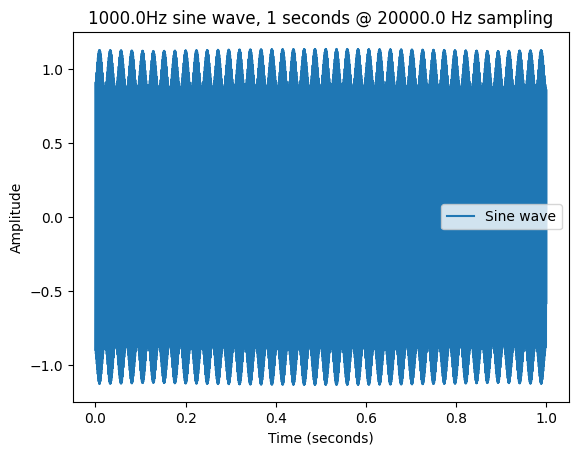

Phase 1: Embedding network training ...
 Step 50/200 | E_loss: 2.6328
 Step 100/200 | E_loss: 0.5088
 Step 150/200 | E_loss: 0.4294
 Step 200/200 | E_loss: 0.3662
Reconstruction error after Phase 1: 0.001152381650172174


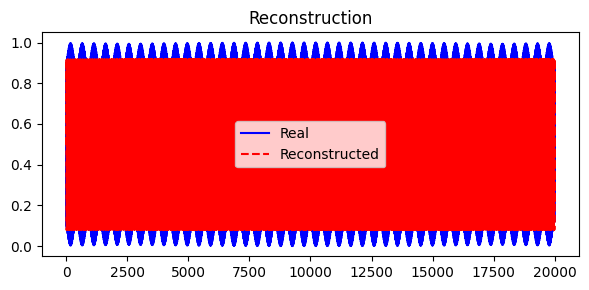

Phase 2: Supervised loss training ...
 Step 50/200 | S_loss: 0.0277
 Step 100/200 | S_loss: 0.0269
 Step 150/200 | S_loss: 0.0260
 Step 200/200 | S_loss: 0.0252
Supervisor next-step error after Phase 2: 0.025176120921969414
Phase 3: Joint training (2 G updates, 1 D update per iteration) ...
 Step 50/200 | G_loss: 12.7880 | D_loss: 2.0331 | E_loss: 0.7750
 Step 100/200 | G_loss: 3.8813 | D_loss: 1.9997 | E_loss: 0.4647
 Step 150/200 | G_loss: 3.1152 | D_loss: 1.9744 | E_loss: 4.0562
Early stopping triggered in Phase 3 at step 185 | G_loss: 2.7180 | D_loss: 1.9718 | E_loss: 1.9949


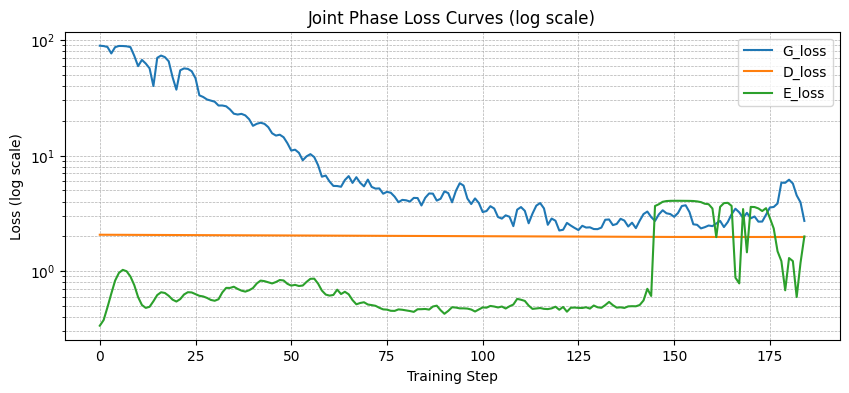

Generating synthetic data ...
Real mean: [2.105967e-06]
Fake mean: [-0.00173799]
Real std: [0.7103769]
Fake std: [0.7253295]
Visualizing data samples ...


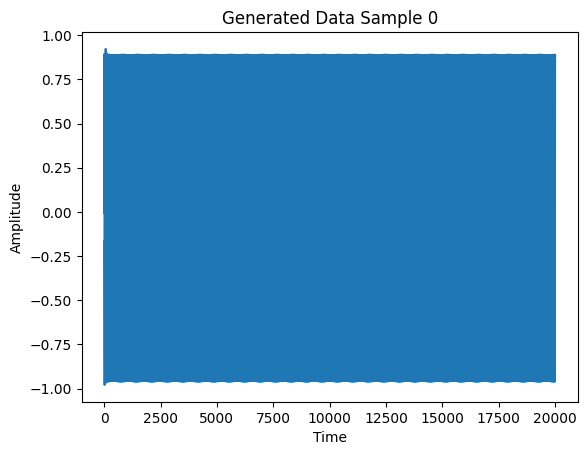

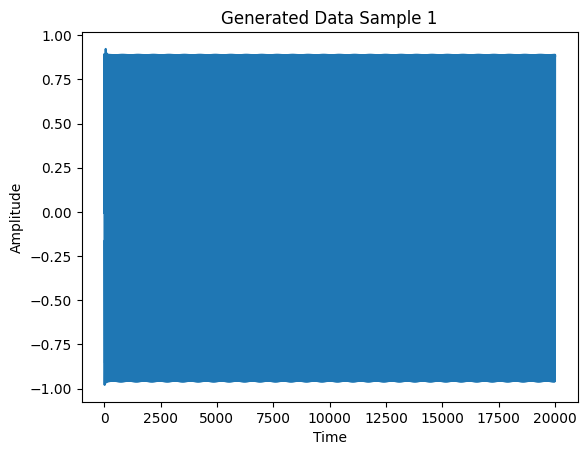

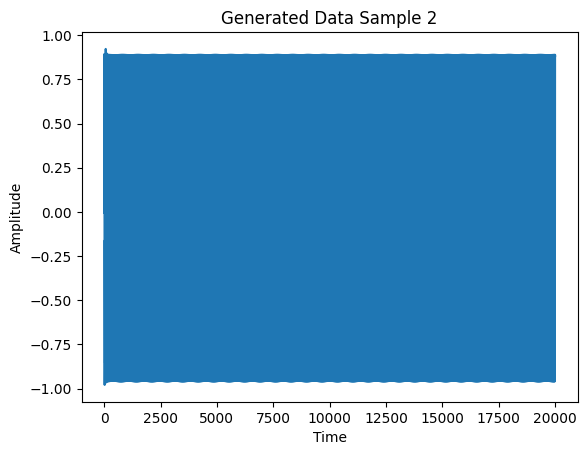

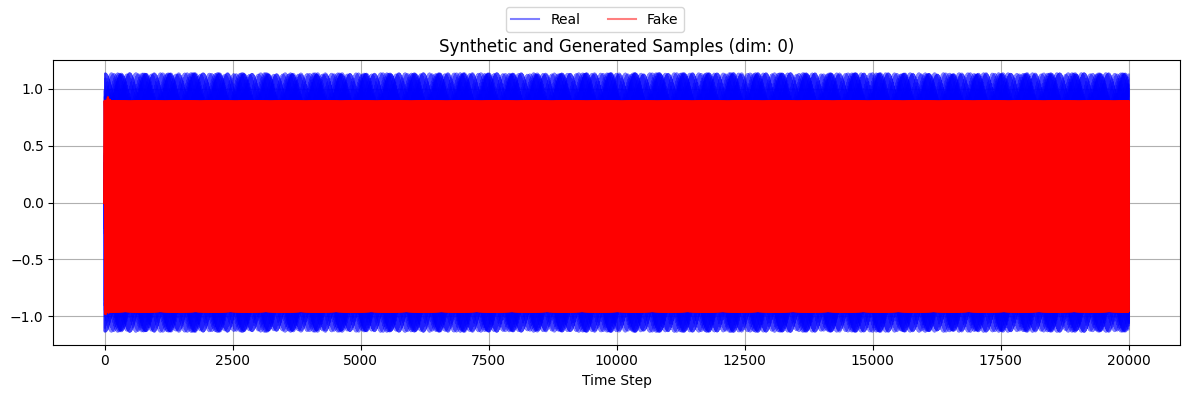

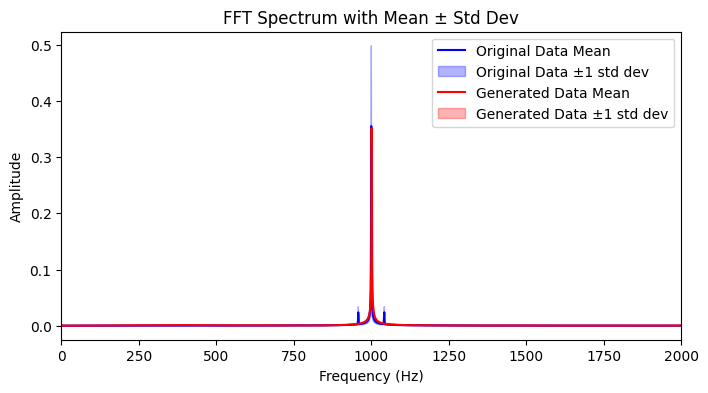

Done!


In [50]:
###############################################################################
# 8) Runs the TimeGAN
###############################################################################
if __name__ == "__main__":
    print("Running TimeGAN TF2 with sub-network pre-building ...")
    ori_data, gen_data = run_timegan_tf2_sine(
        n_samples=1000,
        seq_len=1,
        base_freq=1e3,
        sampling_rate=2e4,
        dim=1,
        hidden_dim=24,
        num_layers=3,
        module='lstm', # LSTM or GRU
        gamma=1.0,
        iterations=200,
        batch_size=32,
        metric_iterations=2,
        patience=64,
        modulation='AM' # FM, AM, or both
    )

    print("Done!")